In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy.random import uniform, randn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [15]:
def load_wiggle():

    np.random.seed(0)
    Npoints = 300
    x = randn(Npoints) * 2.5 + 5  # uniform(0, 10, size=Npoints)

    def function(x):
        return np.sin(np.pi * x) + 0.2 * np.cos(np.pi * x * 4) - 0.3 * x

    y = function(x)

    homo_noise_std = 0.25
    homo_noise = randn(*x.shape) * homo_noise_std
    y = y + homo_noise

    x = x[:, None]
    y = y[:, None]

    x_means, x_stds = x.mean(axis=0), x.std(axis=0)
    y_means, y_stds = y.mean(axis=0), y.std(axis=0)

    X = ((x - x_means) / x_stds).astype(np.float32)
    Y = ((y - y_means) / y_stds).astype(np.float32)

    return X, Y

In [16]:
class Res_MLPblock(nn.Module):
	def __init__(self, width):
		super(Res_MLPblock, self).__init__()
		self.block = nn.Sequential(nn.Linear(width, width), nn.ReLU(), nn.BatchNorm1d(num_features=width))
	def forward(self,x):
		return x + self.block(x)

class Dun_toy(nn.Module):
	def __init__(self, input_dim, hidden_dim, output_dim, n_layer):
		super(Dun_toy, self).__init__()
		self.input_dim = input_dim
		self.output_dim = output_dim
		self.hidden_dim = hidden_dim
		self.n_layer = n_layer
		self.input_layer = nn.Linear(input_dim, hidden_dim)
		self.output_layer = nn.Linear(hidden_dim, output_dim)
		self.hidden_blocks = nn.ModuleList()
		for _ in range(n_layer):
			self.hidden_blocks.append(Res_MLPblock(hidden_dim))

	def forward(self, x, depth=None):
		"""
		x: input
		depth: number of hidden blocks to evaluate
		"""
		depth = self.n_layer if depth is None else depth
		assert depth <= self.n_layer
		# depth * batch_size * output_dim
		act_vec = torch.zeros(depth+1, x.shape[0], self.output_dim).type(x.type())
		x = self.input_layer(x)
		act_vec[0] = self.output_layer(x)
		for i in range(depth):
			x = self.hidden_blocks[i](x)
			act_vec[i+1] = self.output_layer(x)
		return act_vec

In [17]:
class Dataclass(Dataset):

    def __init__(self, x_train, y_train=None, transform=None):
        self.data = x_train
        self.targets = y_train
        self.transform = transform

    def __getitem__(self, index):
        y = self.data[index]
        if self.transform is not None:
            y = self.transform(y)
        if self.targets is not None:
            return y, self.targets[index]
        else:
            return y

    def __len__(self):
        return len(self.data)

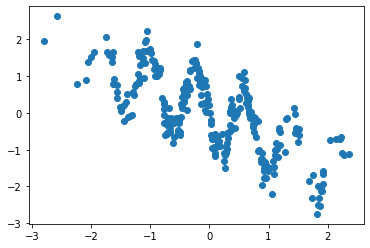

(300, 1) (300, 1)


In [18]:
X, Y = load_wiggle()
plt.scatter(X.flatten(), Y.flatten())
plt.show()
print(X.shape, Y.shape)

trainset = Dataclass(X,Y)
valset = Dataclass(X,Y)

batch_size = len(trainset)
n_cpu = 10
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                          num_workers=n_cpu)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                        num_workers=n_cpu)

In [19]:
class GaussianNLL(nn.Module):
    def __init__(self, input_dim, std=None,eps=1e-6):
        super(GaussianNLL, self).__init__()
        if std is None:
            self.log_std = nn.Parameter(torch.zeros(input_dim))
        else:
            # fix std
            self.log_std = nn.Parameter(torch.ones(input_dim) * np.log(sig), requires_grad=False)
        self.eps = eps

    def forward(self, mean, input):
        std = self.log_std.exp().clamp(min=self.eps)
        var = std**2
        assert input.shape == mean.shape
        batch_size = input.shape[0]
        # if var.shape[1:] != 1:
        #     assert input.shape == var.shape
        # else:
        #     assert var.shape[0] == batch_size
        
        data_shape = input.shape[1:]
        input = input.view(batch_size,-1)
        mean = mean.view(batch_size,-1)
        # var = var.view(batch_size,-1)
        # print(f'input:{input}, mean:{mean}, var:{torch.maximum(var,eps)}')
        NLL = 0.5*torch.sum(torch.log(2*torch.tensor(np.pi)) + torch.log(var) + (input-mean)**2/var,                                                      dim=1).view(batch_size,*data_shape)
        return NLL
    


In [20]:
class VI(nn.Module):
    def __init__(self, prior_prob, N,eps=1e-33):
        super(VI, self).__init__()
        self.N = N
        self.eps = eps
        self.depth = len(prior)
        self.register_buffer('beta', torch.tensor(prior_prob))
        self.register_buffer('log_beta', torch.log(self.beta))
        assert self.beta.sum().item() - 1 < 1e-6
        self.alpha_logits = nn.parameter.Parameter(torch.zeros(self.depth), requires_grad=True)
        self.last_post = None
        self.fNLL = GaussianNLL(1)
    
    def get_probs(self, logits):
        return F.softmax(logits, dim=0)

    def get_logprobs(self, logits):
        return F.log_softmax(logits, dim=0)

    def get_KL(self):
        log_alpha = self.get_logprobs(self.alpha_logits)
        log_beta = self.log_beta
        alpha = self.get_probs(self.alpha_logits).clamp(min=self.eps, max=(1 - self.eps))
        kl_div =  torch.sum(alpha*(log_alpha - log_beta))
        return kl_div
    
    def ppd(self, act_vec):
        alpha = self.get_probs(self.alpha_logits)
        # (1, batch_size, *output_dims)
        mean = torch.sum(act_vec * alpha.view(-1, *((1,)*(len(act_vec.shape)-1))), dim=0)
        var = torch.sum((act_vec**2) * alpha.view(-1, *((1,)*(len(act_vec.shape)-1))), dim=0)
        var = var - mean**2 + self.fNLL.log_std.exp()**2
        return mean, var

    def ELBO(self, y, act_vec):
        batch_size = act_vec.shape[1]
        # (depth, batch_size)
        loglike_per_act = self.get_depth_wise_LL(y, act_vec)
        alpha = self.get_probs(self.alpha_logits)
        wtd_loglike_per_act = loglike_per_act*torch.unsqueeze(alpha,1)
        expected_LL = self.N*torch.sum(wtd_loglike_per_act)/batch_size
        kl_div =  self.get_KL()
        # print(f'KL div: {kl_div}')
        # print(f'expectedll: {expected_LL}')
        return expected_LL - kl_div

    def update_prior(self):
        self.last_post = self.get_probs(self.alpha_logits).detach()


    def get_depth_wise_LL(self, y, act_vec):
        """
        y (batch_size, *output_dims): label
        act_vec (depth, batch, output_dim): scores
        returns ll (depth, batch)
        """
        depth = act_vec.shape[0]
        batch_size = act_vec.shape[1]
        rep_dim = [depth] + [1 for _ in range(len(y.shape)-1)]
        # (depth*batch_size, *output_dims) with batch changing first
        y_expand = y.repeat(*rep_dim)
        # (depth*batch_size, *output_dims) with batch changing first
        act_vec_flat = act_vec.view(depth*batch_size, -1)
        # TODO: use function here
        loglike_per_act = -self.fNLL(act_vec_flat, y_expand).view(depth, batch_size)
        return loglike_per_act

In [24]:
n_layer = 10
N = len(trainset)
prior = [1/(n_layer+1)]*(n_layer+1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Dun_toy(input_dim=X.shape[1], hidden_dim=100, output_dim=Y.shape[1], n_layer=n_layer).to(device)
vi = VI(prior, N).to(device)
params = list(model.parameters()) + list(vi.parameters())
optim = torch.optim.SGD(params,lr=1e-3,momentum = 0.9, weight_decay=0.0001)

In [25]:
# x,y = iter(trainloader).next()
# print(len(trainset))
# print(x.shape, y.shape)
# act_vec = model(x)
# print(act_vec.shape)
# prior = [1/(n_layer+1)]*(n_layer+1)
# elbo = vi.ELBO(y, act_vec)
# print(elbo)

In [27]:
n_epoch = 1000
run_elbo = []
run_depth_prob = []
log_elbo = []
log_depth_prob = []
log_every = 10
criterion = nn.MSELoss()
for epoch in range(n_epoch):
    for itr,(x,y) in enumerate(trainloader):
        vi.update_prior()
        x = x.to(device)
        y = y.to(device)
        act_vec = model(x)
        neg_elbo = -vi.ELBO(y, act_vec)/N
        elbo = -neg_elbo.item()*N
        optim.zero_grad()
        neg_elbo.backward()
        optim.step()
        run_elbo.append(elbo)
        log_elbo.append(elbo)
        run_depth_prob.append(vi.last_post.cpu().numpy())
        log_depth_prob.append(vi.last_post.cpu().numpy())
        # print(vi.beta.cpu().numpy())
        if epoch%log_every == 0:
            print(f'epoch:{epoch+1}, itr:{itr+1} avg. elbo:{np.mean(log_elbo)}')
            print(f'depth prob: {np.mean(log_depth_prob, axis=0)}')
            log_elbo = []
            log_depth_prob = []

epoch:1, itr:1 avg. elbo:-197.07106947898865
depth prob: [0.08972619 0.08947599 0.08992148 0.09079973 0.09108487 0.09153927
 0.09151769 0.09162607 0.0916346  0.09137447 0.09129968]
epoch:11, itr:1 avg. elbo:-191.5647679567337
depth prob: [0.08954094 0.08929969 0.0898103  0.09079538 0.09113719 0.09160286
 0.09158419 0.09169588 0.09170946 0.09144923 0.09137485]
epoch:21, itr:1 avg. elbo:-182.6197385787964
depth prob: [0.08917454 0.0889513  0.08959592 0.09079373 0.09124143 0.09172549
 0.09171431 0.09183167 0.09185492 0.09159499 0.0915217 ]
epoch:31, itr:1 avg. elbo:-175.6904286146164
depth prob: [0.08876572 0.08856305 0.08936477 0.09080175 0.09135815 0.09185813
 0.09185739 0.09198042 0.0920134  0.09175453 0.09168269]
epoch:41, itr:1 avg. elbo:-169.28850710391998
depth prob: [0.08831593 0.08813599 0.08911913 0.09082042 0.09148701 0.09200124
 0.09201275 0.09214129 0.09218372 0.09192668 0.09185589]
epoch:51, itr:1 avg. elbo:-163.24507176876068
depth prob: [0.0878255  0.08767037 0.0888596  0.

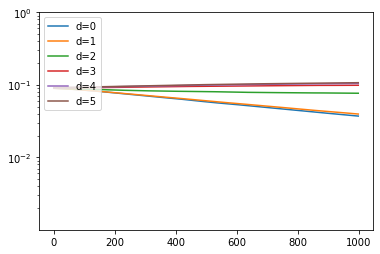

In [28]:
run_depth_prob = np.array(run_depth_prob)
fig, ax = plt.subplots()
ax.plot(range(run_depth_prob.shape[0]),run_depth_prob[:,0], label='d=0')
ax.plot(range(run_depth_prob.shape[0]),run_depth_prob[:,1], label='d=1')
ax.plot(range(run_depth_prob.shape[0]),run_depth_prob[:,2], label='d=2')
ax.plot(range(run_depth_prob.shape[0]),run_depth_prob[:,3], label='d=3')
ax.plot(range(run_depth_prob.shape[0]),run_depth_prob[:,4], label='d=4')
ax.plot(range(run_depth_prob.shape[0]),run_depth_prob[:,5], label='d=5')
ax.set(ylim=(10e-4,1))
ax.set_yscale('log')
ax.set_yticks([10e-3, 10e-2, 10e-1])
ax.legend(loc="upper left")
plt.show()

In [46]:
print(vi.fNLL.log_std.exp()**2)

tensor([0.0908], device='cuda:0', grad_fn=<PowBackward0>)


In [36]:
model.eval()
vi.eval()

VI(
  (fNLL): GaussianNLL()
)

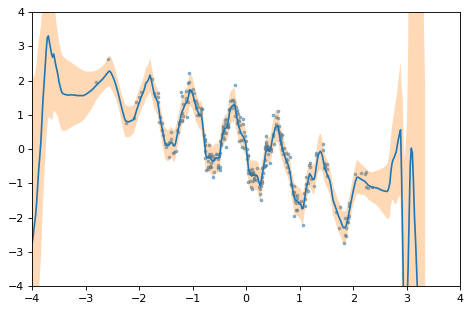

In [49]:

for itr,(x,y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            x_test = torch.arange(torch.min(x)-2, torch.max(x)+1, step=0.02, device = device).view(-1,1)
            act_vec = model(x_test)
            pred_mean, pred_var = vi.ppd(act_vec)
            pred_mean = pred_mean.cpu().numpy()
            pred_var = pred_var +  vi.fNLL.log_std.exp()**2
            pred_var = np.power(pred_var.cpu().numpy(),0.5)
            x = x.cpu().numpy()
            x_test = x_test.cpu().numpy()
            y = y.cpu().numpy() 
            plt.figure(dpi=80)
            plt.xlim(-4,4)
            plt.ylim(-4,4)
            plt.tight_layout()
            plt.scatter(x,y, s=5, alpha=0.5,)
            plt.plot(x_test,pred_mean)
            # plt.plot(x_test, act_vec.cpu().numpy()[5])
            # print(x_test.shape, pred_mean.shape, pred_var.shape)
            plt.fill_between(x_test.squeeze(), pred_mean.squeeze() - pred_var.squeeze(), 
                            pred_mean.squeeze()+pred_var.squeeze(),alpha=0.3)
            plt.show()
